# Experiments for master's thesis


## Setup

Settings

In [1]:
CONFIG = {'artifacts_dir': 'artifacts'}

Prep for experiments

In [2]:
from typing import Tuple, Callable, List, Union
import torchvision
import numpy
import torch
from lrp import norm, image

# Normalization
norm_fn: Callable[[torch.Tensor], torch.Tensor] = norm.ILSVRC2012_BatchNorm()

# Input data
img: numpy.array = image.load_normalized_img('../data/castle.jpg')
X: torch.Tensor = norm_fn(image.img_to_tensor(img))

# Model
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = norm_fn(torch.zeros(*shape))
high: torch.Tensor = norm_fn(torch.ones(*shape))

## Hyperparameter Grid Search

In [3]:
from lrp.rules import LrpZBoxRule, LrpGammaRule, LrpEpsilonRule, LrpZeroRule

from typing import List, Dict, Union, Tuple
from lrp.filter import LayerFilter
from lrp.zennit.types import AvgPool, Linear
import lrp.rules as rules

import experiments
import lrp.plot

# Init layer filter
vgg16_target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type = LayerFilter(model)
filter_by_layer_index_type.set_target_types(vgg16_target_types)

# Init epsilon and gamma values for hyperparameter search
hyperparams: numpy.ndarray = numpy.linspace(0.0, 1.0, num=20)

### Composite ZBox-Gamma Rule

Create a grid search for the gamma rule.

In [4]:
hyperparam_name: str = 'gamma'
output_dir_path: str = f'{CONFIG["artifacts_dir"]}/composite/zbox-{hyperparam_name}'

# Rule-Layer Mapping
name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: n>= 1), LrpGammaRule, {hyperparam_name: None}),
]

def name_map_hyperparam_setter(hyperparam_val: float) -> None:
    r'''Set the missing hyperparameter for the LRP rule.

    :param hyperparam_val: The value of the hyperparameter.
    '''
    name_map[1][2][hyperparam_name] = hyperparam_val

e = experiments.Experiments(model, X, name_map, output_dir_path)
results: List[Tuple[float, torch.Tensor]]
results = e.generate_multiple_lrp_relevances(hyperparams, name_map_hyperparam_setter)

Using cached results


#### Grid plot

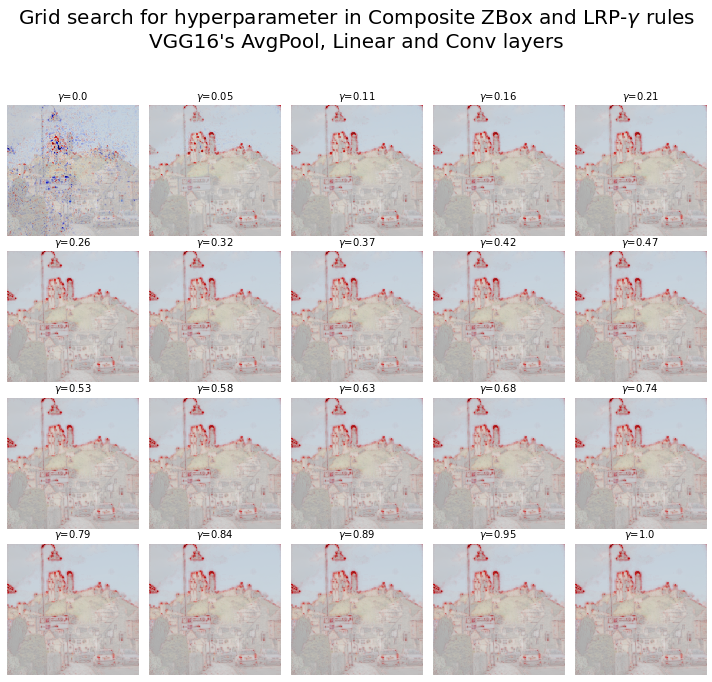

In [5]:
title: str = f"Grid search for hyperparameter in Composite ZBox and LRP-$\{hyperparam_name}$ rules\nVGG16's AvgPool, Linear and Conv layers"
filename: str = f'composite-zbox-{hyperparam_name}s-lrp.png'

lrp.plot.grid(results,
              title=title,
              filename=f'{output_dir_path}/{filename}',
              image=img,
              gridsize=(4, 5),
              param_name=f'$\{hyperparam_name}$',
              param_print=lambda p: round(p, 2))

### Composite ZBox-Epsilon Rule

Create a grid search for the epsilon rule.

In [6]:
hyperparam_name: str = 'epsilon'
output_dir_path: str = f'{CONFIG["artifacts_dir"]}/composite/zbox-{hyperparam_name}'

# Rule-Layer Mapping
name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: n>= 1), LrpEpsilonRule, {hyperparam_name: None}),
]

def name_map_hyperparam_setter(hyperparam_val: float) -> None:
    r'''Set the missing hyperparameter for the LRP rule.

    :param hyperparam_val: The value of the hyperparameter.
    '''
    name_map[1][2][hyperparam_name] = hyperparam_val

e = experiments.Experiments(model, X, name_map, output_dir_path)
results: List[Tuple[float, torch.Tensor]]
results = e.generate_multiple_lrp_relevances(hyperparams, name_map_hyperparam_setter)

Using cached results


#### Grid plot

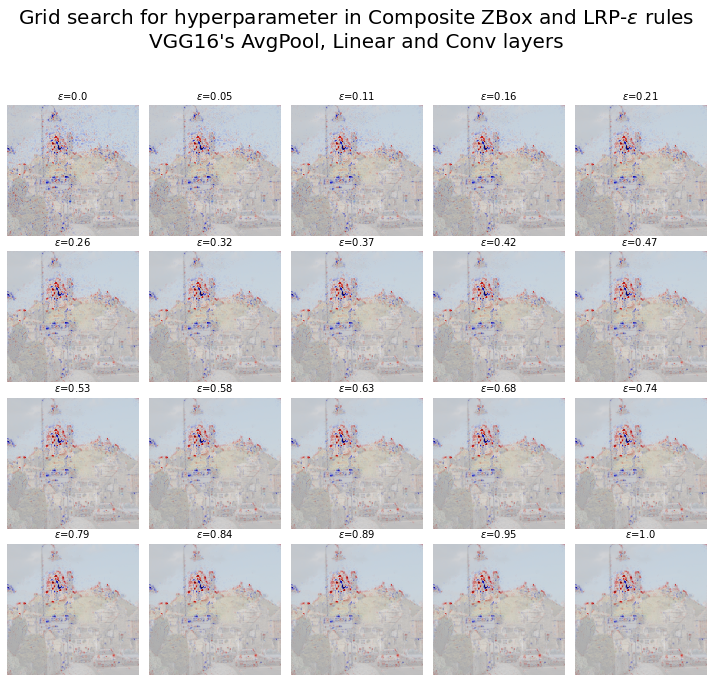

In [7]:
title: str = f"Grid search for hyperparameter in Composite ZBox and LRP-$\{hyperparam_name}$ rules\nVGG16's AvgPool, Linear and Conv layers"
filename: str = f'composite-zbox-{hyperparam_name}s-lrp.png'

lrp.plot.grid(results,
              title=title,
              filename=f'{output_dir_path}/{filename}',
              image=img,
              gridsize=(4, 5),
              param_name=f'$\{hyperparam_name}$',
              param_print=lambda p: round(p, 2))

### Composite-LRP: Gamma Rule

Create a grid search for the gamma rule in a composite mapping.

In [8]:
hyperparam_name: str = 'gamma'
output_dir_path: str = f'{CONFIG["artifacts_dir"]}/composite/gamma'

# Rule-Layer Mapping
name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': None}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

def name_map_hyperparam_setter(gamma: float) -> None:
    r'''Set the missing hyperparameter for the LRP rule.

    :param gamma: The value of the hyperparameter.
    '''
    name_map[1][2]['gamma'] = gamma

e = experiments.Experiments(model, X, name_map, output_dir_path)
results: List[Tuple[float, torch.Tensor]]
results = e.generate_multiple_lrp_relevances(hyperparams, name_map_hyperparam_setter)

Using cached results


#### Grid plot

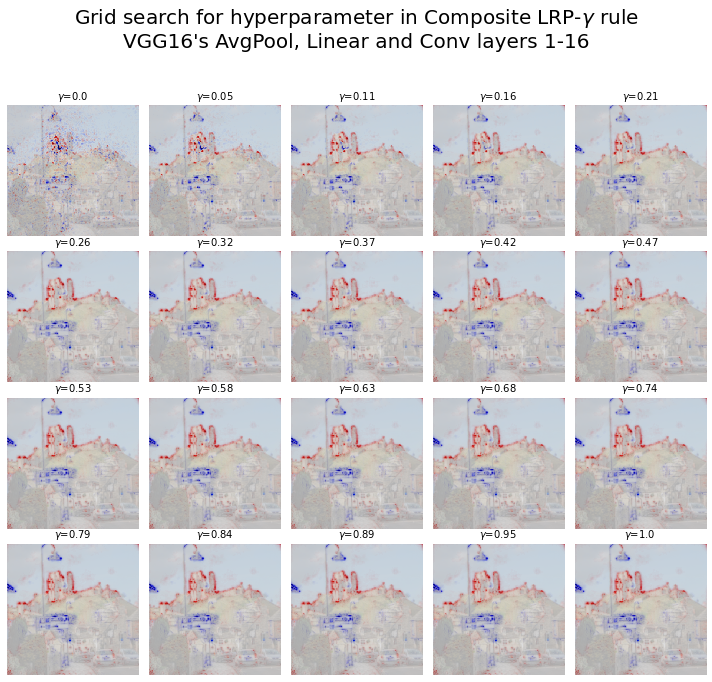

In [9]:
title: str = "Grid search for hyperparameter in Composite LRP-$\gamma$ rule\nVGG16's AvgPool, Linear and Conv layers 1-16"
filename: str = 'composite-gammas-lrp.png'

lrp.plot.grid(results,
              title=title,
              filename=f'{output_dir_path}/{filename}',
              image=img,
              gridsize=(4, 5),
              param_name='$\gamma$',
              param_print=lambda p: round(p, 2))

### Composite-LRP: Epsilon Rule

Create a grid search for the epsilon rule in a composite mapping.

In [10]:
hyperparam_name: str = 'epsilon'
output_dir_path: str = f'{CONFIG["artifacts_dir"]}/composite/epsilon'

# Rule-Layer Mapping
name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0.25}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': None}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

def name_map_hyperparam_setter(epsilon: float) -> None:
    r'''Set the missing hyperparameter for the LRP rule.

    :param epsilon: The value of the hyperparameter.
    '''
    name_map[2][2]['epsilon'] = epsilon

e = experiments.Experiments(model, X, name_map, output_dir_path)
results: List[Tuple[float, torch.Tensor]]
results = e.generate_multiple_lrp_relevances(hyperparams, name_map_hyperparam_setter)

Using cached results


#### Grid plot

In [11]:
title: str = "Grid search for hyperparameter in Composite LRP-$\epsilon$ rule\nVGG16's AvgPool, Linear and Conv layers 17-30"
filename: str = 'composite-epsilons-lrp.png'

lrp.plot.grid(results,
              title=title,
              filename=f'{output_dir_path}/{filename}',
              image=img,
              gridsize=(4, 5),
              param_name='$\epsilon$',
              param_print=lambda p: round(p, 2))

### Uniform Gamma Rule

Create a grid search for the gamma rule.

In [ ]:
hyperparam_name: str = 'gamma'
output_dir_path: str = f'{CONFIG["artifacts_dir"]}/uniform/gamma'

# Rule-Layer Mapping
name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n >= 1), LrpGammaRule, {'gamma': None})
]

def name_map_hyperparam_setter(gamma: float) -> None:
    r'''Set the missing hyperparameter for the LRP rule.

    :param gamma: The value of the hyperparameter.
    '''
    name_map[0][2]['gamma'] = gamma

e = experiments.Experiments(model, X, name_map, output_dir_path)
results: List[Tuple[float, torch.Tensor]]
results = e.generate_multiple_lrp_relevances(hyperparams, name_map_hyperparam_setter)

Using cached results


#### Grid plot

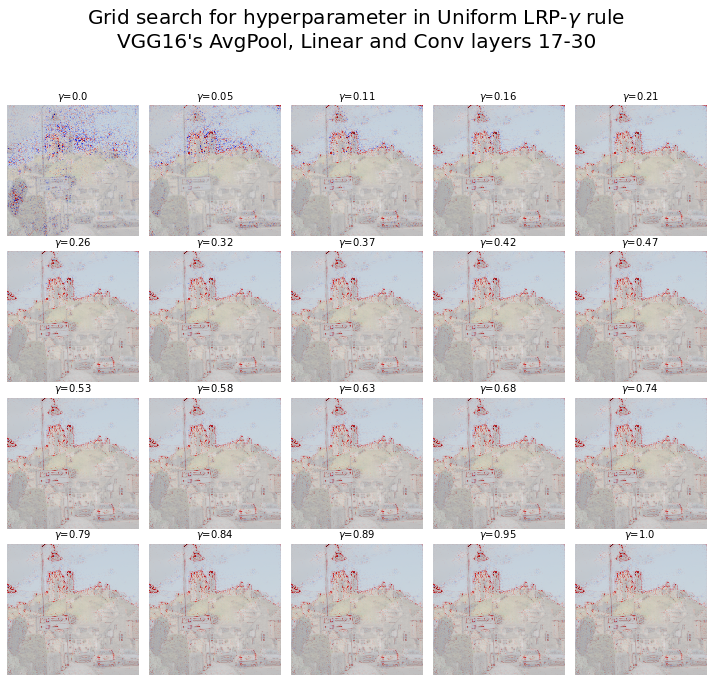

In [ ]:
title: str = "Grid search for hyperparameter in Uniform LRP-$\gamma$ rule\nVGG16's AvgPool, Linear and Conv layers 17-30"
filename: str = 'uniform-gammas-lrp.png'

lrp.plot.grid(results,
              title=title,
              filename=f'{output_dir_path}/{filename}',
              image=img,
              gridsize=(4, 5),
              param_name='$\gamma$',
              param_print=lambda p: round(p, 2))

### Uniform Epsilon Rule

Create a grid search for the epsilon rule.

In [ ]:
hyperparam_name: str = 'epsilon'
output_dir_path: str = f'{CONFIG["artifacts_dir"]}/uniform/{hyperparam_name}'

# Rule-Layer Mapping
name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n >= 1), LrpEpsilonRule, {hyperparam_name: None})
]

def name_map_hyperparam_setter(hyperparam_val: float) -> None:
    r'''Set the missing hyperparameter for the LRP rule.

    :param hyperparam_val: The value of the hyperparameter.
    '''
    name_map[0][2][hyperparam_name] = hyperparam_val

e = experiments.Experiments(model, X, name_map, output_dir_path)
results: List[Tuple[float, torch.Tensor]]
results = e.generate_multiple_lrp_relevances(hyperparams, name_map_hyperparam_setter)

Using cached results


#### Grid plot

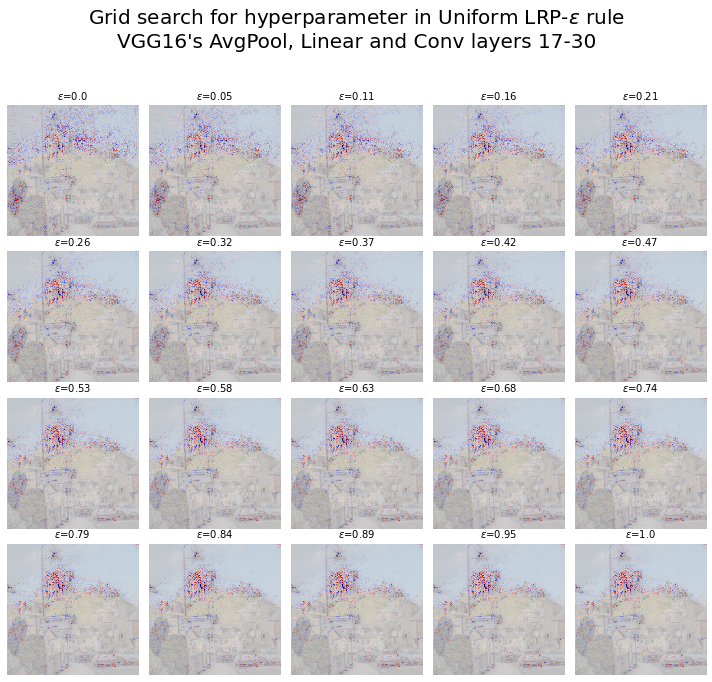

In [ ]:
title: str = f"Grid search for hyperparameter in Uniform LRP-$\{hyperparam_name}$ rule\nVGG16's AvgPool, Linear and Conv layers 17-30"
filename: str = f'uniform-{hyperparam_name}s-lrp.png'

lrp.plot.grid(results,
              title=title,
              filename=f'{output_dir_path}/{filename}',
              image=img,
              gridsize=(4, 5),
              param_name=f'$\{hyperparam_name}$',
              param_print=lambda p: round(p, 2))